In [1]:
# the code is created using the following tutorials:
# https://www.pyimagesearch.com/2020/11/23/building-image-pairs-for-siamese-networks-with-python/
# https://www.pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/
# https://www.pyimagesearch.com/2020/12/07/comparing-images-for-similarity-using-siamese-networks-keras-and-tensorflow/

In [2]:
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from imutils import build_montages
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In [4]:
with strategy.scope():
    (trainX, trainY), (testX, testY) = mnist.load_data()

In [5]:
def make_pairs(images, labels):
    pairImages=[]
    pairLabels=[]
    numClasses = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
    for i in range(0, numClasses):
        idxs = np.where(labels == i)[0]
        print("{}: {} {}".format(i, len(idxs), idxs))
    for idxA in range(len(images)):
        currentImage = images[idxA]
        label = labels[idxA]
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]
        pairImages.append([currentImage, posImage])
        pairLabels.append([1])
        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]
        pairImages.append([currentImage, negImage])
        pairLabels.append([0])
    return (np.array(pairImages), np.array(pairLabels))

In [6]:
(pairTrain_vis, labelTrain_vis) = make_pairs(trainX, trainY)
(pairTest_vis, labelTest_vis) = make_pairs(testX, testY)

0: 5923 [    1    21    34 ... 59952 59972 59987]
1: 6742 [    3     6     8 ... 59979 59984 59994]
2: 5958 [    5    16    25 ... 59983 59985 59991]
3: 6131 [    7    10    12 ... 59978 59980 59996]
4: 5842 [    2     9    20 ... 59943 59951 59975]
5: 5421 [    0    11    35 ... 59968 59993 59997]
6: 5918 [   13    18    32 ... 59982 59986 59998]
7: 6265 [   15    29    38 ... 59963 59977 59988]
8: 5851 [   17    31    41 ... 59989 59995 59999]
9: 5949 [    4    19    22 ... 59973 59990 59992]
0: 980 [   3   10   13   25   28   55   69   71  101  126  136  148  157  183
  188  192  194  215  246  269  271  294  296  297  305  311  312  324
  327  346  365  372  380  407  424  440  441  443  459  485  490  498
  525  545  546  552  561  564  567  581  586  592  597  608  611  620
  642  644  656  661  701  704  713  717  721  723  742  750  763  794
  804  821  845  851  854  871  884  895  896  904  932  972  981  993
  997 1001 1009 1034 1047 1061 1084 1094 1121 1148 1154 1176 1188 1

In [7]:
images = []
for i in np.random.choice(np.arange(0, len(pairTrain_vis)), size=(49,)):
    # grab the current image pair and label
    imageA = pairTrain_vis[i][0]
    imageB = pairTrain_vis[i][1]
    label = labelTrain_vis[i]
    
    output = np.zeros((36, 60), dtype="uint8")
    pair = np.hstack([imageA, imageB])
    output[4:32, 0:56] = pair
    
    text = "neg" if label[0] == 0 else "pos"
    color = (0, 0, 255) if label[0] == 0 else (0, 255, 0)
    
    vis = cv2.merge([output] * 3)
    vis = cv2.resize(vis, (96, 51), interpolation=cv2.INTER_LINEAR)
    cv2.putText(vis, text, (2, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
        color, 2)

    images.append(vis)

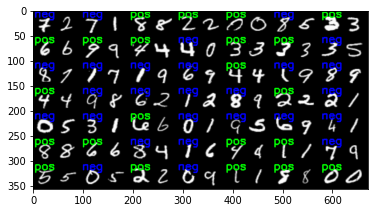

In [8]:
montage = build_montages(images, (96, 51), (7, 7))[0]
plt.imshow(montage)

In [9]:
import os
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 64
EPOCHS = 4

BASE_OUTPUT = "output"
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D

In [11]:
def build_siamese_model(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs)
    return model

In [12]:
def euclidean_distance(vectors):

    (featsA, featsB) = vectors

    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
        keepdims=True)

    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [13]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist

In [14]:
with strategy.scope():
    trainX = trainX / 255.0
    testX = testX / 255.0

    trainX = np.expand_dims(trainX, axis=-1)
    testX = np.expand_dims(testX, axis=-1)

    (pairTrain, labelTrain) = make_pairs(trainX, trainY)
    (pairTest, labelTest) = make_pairs(testX, testY)

0: 5923 [    1    21    34 ... 59952 59972 59987]
1: 6742 [    3     6     8 ... 59979 59984 59994]
2: 5958 [    5    16    25 ... 59983 59985 59991]
3: 6131 [    7    10    12 ... 59978 59980 59996]
4: 5842 [    2     9    20 ... 59943 59951 59975]
5: 5421 [    0    11    35 ... 59968 59993 59997]
6: 5918 [   13    18    32 ... 59982 59986 59998]
7: 6265 [   15    29    38 ... 59963 59977 59988]
8: 5851 [   17    31    41 ... 59989 59995 59999]
9: 5949 [    4    19    22 ... 59973 59990 59992]
0: 980 [   3   10   13   25   28   55   69   71  101  126  136  148  157  183
  188  192  194  215  246  269  271  294  296  297  305  311  312  324
  327  346  365  372  380  407  424  440  441  443  459  485  490  498
  525  545  546  552  561  564  567  581  586  592  597  608  611  620
  642  644  656  661  701  704  713  717  721  723  742  750  763  794
  804  821  845  851  854  871  884  895  896  904  932  972  981  993
  997 1001 1009 1034 1047 1061 1084 1094 1121 1148 1154 1176 1188 1

In [15]:
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
with strategy.scope():
    featureExtractor = build_siamese_model(IMG_SHAPE)
    featsA = featureExtractor(imgA)
    featsB = featureExtractor(imgB)
    distance = Lambda(euclidean_distance)([featsA, featsB])
    outputs = Dense(1, activation="sigmoid")(distance)
    model = Model(inputs=[imgA, imgB], outputs=outputs)

In [16]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 48)           19888       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           functional_1[0][0]    

In [17]:
with strategy.scope():
    model.compile(loss="binary_crossentropy", optimizer="adam",
        metrics=["accuracy"])

# train the model
print("training model...")
history = model.fit(
    [pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
    validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS)

training model...
1875/1875 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.4978WARNING:tensorflow:From /media/eralpkocas/hdd/miniconda3/envs/aienv/lib/python3.8/site-packages/tensorflow/python/data/ops/multi_device_iterator_ops.py:601: get_next_as_optional (from tensorflow.python.data.ops.iterator_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
1875/1875 [==============================] - 110s 59ms/step - loss: 0.6933 - accuracy: 0.4978 - val_loss: 0.6933 - val_accuracy: 0.5001


In [18]:
def plot_training(H, plotPath):

    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

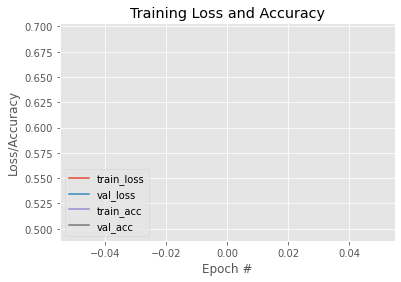

In [19]:
# plot the training history
plot_training(history, PLOT_PATH)

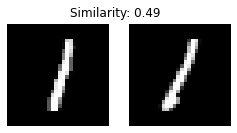

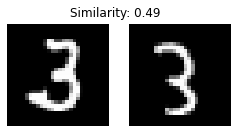

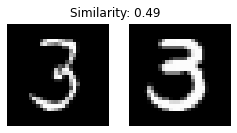

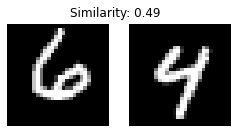

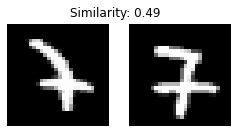

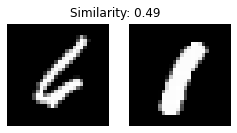

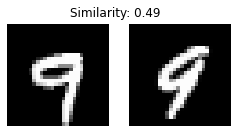

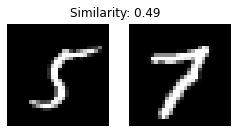

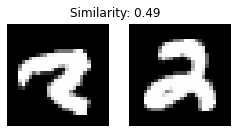

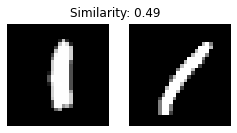

In [20]:
import numpy as np
num_test = len(pairTest)
pairs = np.random.choice(num_test, 10)
for i, idx in enumerate(pairs):
    # load both the images and convert them to grayscale
    imageA = pairTest[idx][0]
    imageB = pairTest[idx][1]
    # create a copy of both the images for visualization purpose
    origA = imageA.copy()
    origB = imageB.copy()
    # add channel a dimension to both the images
    imageA = np.expand_dims(imageA, axis=-1)
    imageB = np.expand_dims(imageB, axis=-1)
    # add a batch dimension to both images
    imageA = np.expand_dims(imageA, axis=0)
    imageB = np.expand_dims(imageB, axis=0)
    # scale the pixel values to the range of [0, 1]
    imageA = imageA / 255.0
    imageB = imageB / 255.0
    # use our siamese model to make predictions on the image pair,
    # indicating whether or not the images belong to the same class
    preds = model.predict([imageA, imageB])
    proba = preds[0][0]
    	# initialize the figure
    fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
    plt.suptitle("Similarity: {:.2f}".format(proba))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(origA, cmap=plt.cm.gray)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(origB, cmap=plt.cm.gray)
    plt.axis("off")
    # show the plot
    plt.show()